<h1><center>IST707 Data Analytics</center></h1>
<h2><center>HW4: Statistical Learning, Deep Learning and A Complete Comparison</center></h2>
<h3><center>Pranav Kottoli Radhakrishna, April 26th 2020</center></h3>

## Introduction

**The purpose of this assignment is to predict whether a patient has a disease based on biological information about the patient such as age and height. We will exlore and process the data in order to prepare it to be used to train machine learning algorithms. This is a binary classification problem. Therefore we will use a number of classification algorithms to make the prediction. We have a training dataset to train the machine learning algorithms and a testing dataset in order to test the predictions made by the algorithms. Additionally, we will compare the results of the models from this assignment with the models in the previous assignment**

## Executive Summary

**We start the asignment by performing feature engineering by adding a new attribute(Body Mass Index). We proceed by performing Exploratory Data analysis where we look at missing values, outliers, correlation and patterns in the data through a combination of visualization and statistical analysis. This is followed by data preparation where we handle outliers and other anomalies that are present in the data. We also scale and one hot encode the data in order to prepare it for our machine learning algorithms**

**Next, we model our data using different classification algorithms. We use Logistic Regression, Decision Trees and Artificial Neural Networks. We then compare the results of these algorithms with the results from the previous assignment.**

**Finally, we make predictions on the test dataset and export the outcomes to a csv file**

## Import Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mn
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,f1_score, accuracy_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [0]:
plt.style.use('seaborn-bright')

## Import the Data

In [0]:
df = pd.read_csv("Disease Prediction Training(2).csv")

In [0]:
df_testing = pd.read_csv("Disease Prediction Testing(2).csv")

# Data Preparation

**Let's start of by adding the attribute body mass index(BMI) to the dataset. BMI can be calculated from height and weight using the formula:**

$$ w / h^2$$

**Where w is in kilograms and h is in metres. We can see further down that the new attribute has a relatively strong correlation with the target variable**

In [0]:
df['BMI'] = df['Weight']/((df['Height']/100)**2)

In [0]:
df_testing['BMI'] = df_testing['Weight']/((df_testing['Height']/100)**2)

## Exploratory Data Analysis

In [7]:
df.head()

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease,BMI
0,59,female,167,88.0,130,68,normal,normal,0,0,1,0,31.553659
1,64,female,150,71.0,140,100,normal,normal,0,0,0,1,31.555556
2,41,female,166,83.0,100,70,normal,normal,0,1,1,0,30.120482
3,50,male,172,110.0,130,80,normal,normal,1,0,1,0,37.182261
4,39,female,162,61.0,110,80,high,high,0,0,1,0,23.243408


In [8]:
df.describe()

,Age,Height,Weight,High Blood Pressure,Low Blood Pressure,Smoke,Alcohol,Exercise,Disease,BMI
count,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000
mean,52.853306,164.366878,74.190527,128.698939,96.917367,0.088265,0.054245,0.803204,0.499959,27.550049
std,6.763065,8.216637,14.329934,147.624582,200.368069,0.283683,0.226503,0.397581,0.500005,6.067360
min,29.000000,55.000000,10.000000,-150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.471784
25%,48.000000,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,53.000000,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000,26.397977
75%,58.000000,170.000000,82.000000,140.000000,90.000000,0.000000,0.000000,1.000000,1.000000,30.163746
max,64.000000,207.000000,200.000000,14020.000000,11000.000000,1.000000,1.000000,1.000000,1.000000,298.666667


In [9]:
df.corr()

,Age,Height,Weight,High Blood Pressure,Low Blood Pressure,Smoke,Alcohol,Exercise,Disease,BMI
Age,1.000000,-0.077621,0.054611,0.024186,0.015983,-0.050065,-0.028419,-0.011579,0.239784,0.086350
Height,-0.077621,1.000000,0.291676,0.002917,0.005524,0.186391,0.093549,-0.007061,-0.011022,-0.296359
Weight,0.054611,0.291676,1.000000,0.031973,0.041933,0.063138,0.061883,-0.017145,0.181836,0.756235
High Blood Pressure,0.024186,0.002917,0.031973,1.000000,0.016065,-0.000820,0.001555,0.002153,0.053667,0.027014
Low Blood Pressure,0.015983,0.005524,0.041933,0.016065,1.000000,0.005267,0.012807,0.002568,0.060944,0.033772
Smoke,-0.050065,0.186391,0.063138,-0.000820,0.005267,1.000000,0.337435,0.026082,-0.014579,-0.031568
Alcohol,-0.028419,0.093549,0.061883,0.001555,0.012807,0.337435,1.000000,0.026081,-0.004486,0.008615
Exercise,-0.011579,-0.007061,-0.017145,0.002153,0.002568,0.026082,0.026081,1.000000,-0.035202,-0.014548
Disease,0.239784,-0.011022,0.181836,0.053667,0.060944,-0.014579,-0.004486,-0.035202,1.000000,0.165530
BMI,0.086350,-0.296359,0.756235,0.027014,0.033772,-0.031568,0.008615,-0.014548,0.165530,1.000000


In [10]:
df.shape

(49000, 13)

### Search for missing values

**The dataset contains no missing values**

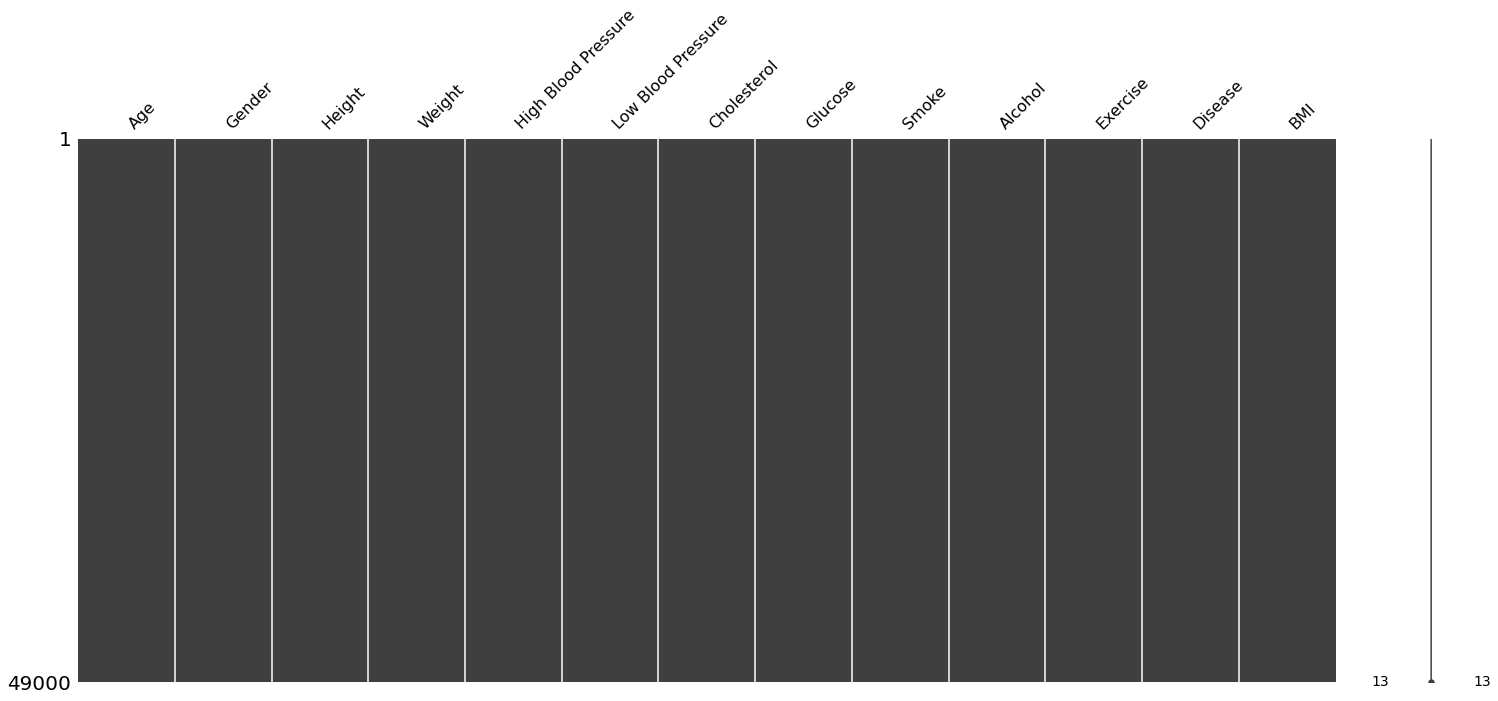

In [11]:
mn.matrix(df)
plt.show()

In [12]:
df.isna().sum().sum()

0

### Let's Visualize the data

In [0]:
def plot_dist_grid(row,col,cols):
    
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(12,10))
    i = 0
    for ax in axes.flatten():
        sns.distplot(df[cols[i]],ax= ax,kde = False)
        i += 1
    
    # Display the figure object    
    fig
    plt.tight_layout()

In [0]:
def plot_count_grid(row,col,cols):
    
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(12,10))
    i = 0
    for ax in axes.flatten():
        sns.countplot(x = cols[i],ax= ax,data = df)
        i += 1
    
    # Display the figure object    
    fig
    plt.tight_layout()

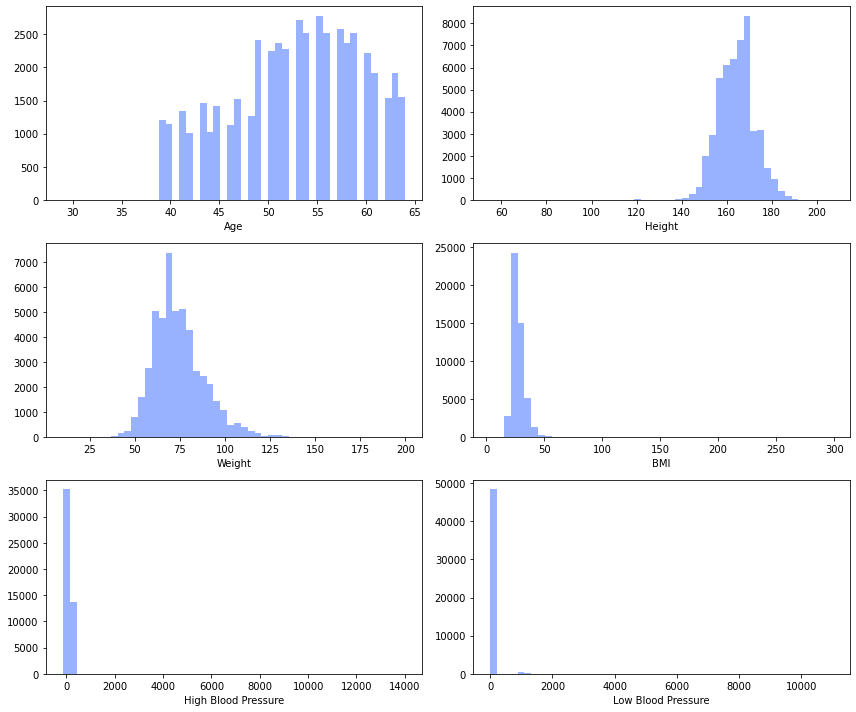

In [15]:
plot_dist_grid(3,2,['Age','Height','Weight','BMI','High Blood Pressure','Low Blood Pressure'])

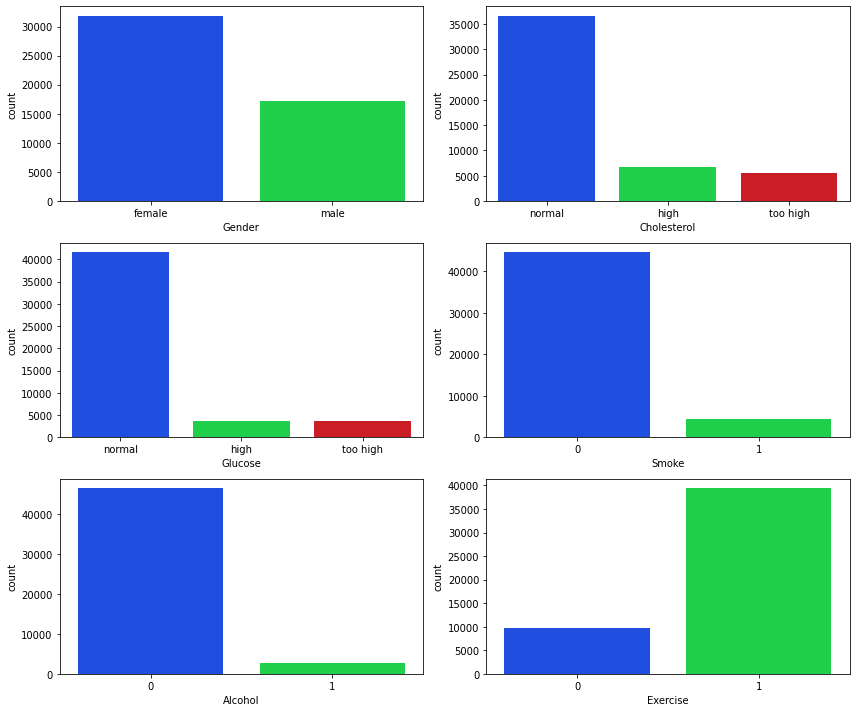

In [16]:
plot_count_grid(3,2,['Gender','Cholesterol','Glucose','Smoke','Alcohol','Exercise'])

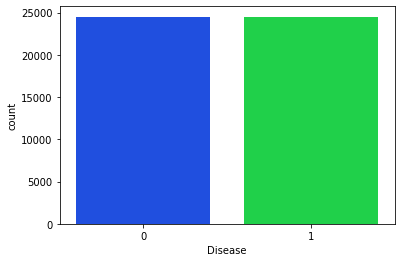

In [17]:
sns.countplot('Disease',data = df)

### Handling Outliers

**Some attributes like Low Blood Pressure, High Blood Pressure and BMI contain outliers. We deal with this by winsorizing these attributes. The value to which the outliers are winsorized is based on domain knowledge. Additionally, some attributes like High Blood Pressure and low Blood Pressure contain negative values which don't make sense, these values will also be handled by this process.**

In [0]:
def winsorize(data,column,upper,lower):
    for j, val in enumerate(column):
        Q1 = np.quantile(data[val],0.25)
        Q3 = np.quantile(data[val],0.75)
        IQR = Q3-Q1

        upper_bound = Q3 + (1.5 * IQR)
        lower_bound = Q1 - (1.5 * IQR)

        high_outliers = data[val][data[val] > upper_bound]
        low_outliers  = data[val][data[val] < lower_bound]

        upper_value = np.quantile(data[val],upper[j])
        lower_value = np.quantile(data[val],lower[j])

        for i in high_outliers.index:
            data.at[i,val] = upper_value

        for i in low_outliers.index:
            data.at[i,val] = lower_value
    
    return data

In [0]:
df = winsorize(df,['Low Blood Pressure','High Blood Pressure','BMI'],[0.986,0.998,0.97],[0.01,0.01,0.001])

In [0]:
df_testing = winsorize(df_testing,['Low Blood Pressure','High Blood Pressure','BMI'],[0.9855,0.998,0.97],[0.01,0.01,0.001])

**We find that the value of low blood pressure is higher than high blood pressure in some of the rows. We handle this by reversing the values**

In [0]:
ind = df[df['Low Blood Pressure'] > df['High Blood Pressure']].index
high = df['High Blood Pressure'].iloc[ind]
low  = df['Low Blood Pressure'].iloc[ind]
for i in ind:
    df.at[i,'High Blood Pressure'] = df['Low Blood Pressure'].iloc[i]
    df.at[i,'Low Blood Pressure']  = df['High Blood Pressure'].iloc[i]

In [0]:
ind = df_testing[df_testing['Low Blood Pressure'] > df_testing['High Blood Pressure']].index
high = df_testing['High Blood Pressure'].iloc[ind]
low  = df_testing['Low Blood Pressure'].iloc[ind]
for i in ind:
    df_testing.at[i,'High Blood Pressure'] = df_testing['Low Blood Pressure'].iloc[i]
    df_testing.at[i,'Low Blood Pressure']  = df_testing['High Blood Pressure'].iloc[i]

### Handle Duplicates

**The dataset contains some duplicate values. These can be dropped**

In [23]:
df[df.duplicated()].head()

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease,BMI
1278,40,female,156,65.0,110,80,normal,normal,0,0,1,0,26.709402
1581,56,female,160,60.0,120,80,normal,normal,0,0,1,1,23.437500
1901,54,female,170,80.0,120,80,normal,normal,0,0,1,0,27.681661
2412,41,female,162,65.0,110,70,normal,normal,0,0,1,0,24.767566
3027,56,female,169,70.0,120,80,normal,normal,0,0,1,0,24.508946


In [0]:
df.drop_duplicates(inplace=True)

In [0]:
df_testing.drop_duplicates(inplace=True)

### One hot encoding

**Certain algorithms cannot have categorical variables. In order to deal with this we create dummy variables**

In [0]:
def create_dummies(data,col_list):
    
    for col_name in col_list:
        
        drop_first = False
        if len(data[col_name].value_counts().index) == 2:
            drop_first = True
            
        tempdf = pd.get_dummies(data[col_name],drop_first = drop_first)
        
        if not drop_first:
            tempdf.columns = [col_name +'_' + str(col) for col in tempdf.columns]
        else:
            tempdf.columns = [col_name]
            
        data = data.drop(col_name,axis = 1).join(tempdf)
        
    return data

In [0]:
df_one_hot = create_dummies(df,['Gender','Glucose','Cholesterol'])

In [0]:
df_test_one_hot = create_dummies(df_testing,['Gender','Glucose','Cholesterol'])

### Let's scale the data

**Since we are running artificial neural networks, we have to scale the data**

In [0]:
min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_one_hot)
df_normalized = pd.DataFrame(np_scaled, columns=df_one_hot.columns, index=df_one_hot.index)

standard_scaler = StandardScaler()
np_scaled = standard_scaler.fit_transform(df_one_hot.drop('Disease',axis = 1))

df_standardized = pd.DataFrame(np_scaled, columns=df_one_hot.drop('Disease',axis = 1).columns, index=df_one_hot.drop('Disease',axis = 1).index)
df_standardized['Disease'] = df_one_hot['Disease']

In [0]:
min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_test_one_hot.drop('ID',axis = 1))
df_test_normalized = pd.DataFrame(np_scaled, columns=df_test_one_hot.drop('ID',axis = 1).columns, index=df_test_one_hot.drop('ID',axis = 1).index)
df_test_normalized['ID'] = df_test_one_hot['ID']

standard_scaler = StandardScaler()
np_scaled = standard_scaler.fit_transform(df_test_one_hot.drop('ID',axis = 1))

df_test_standardized = pd.DataFrame(np_scaled, columns=df_test_one_hot.drop('ID',axis = 1).columns, index=df_test_one_hot.drop('ID',axis = 1).index)
df_test_standardized['ID'] = df_test_one_hot['ID']

# Data Modeling

**The evaluation metric to be optimized are recall and accuracy. It's important to mininimize False Negatives, since it's better to predict that the patient has the disease and have that be false than to predict that they don't and have someone go undiagnosed**

**Let's create a function to plot an ROC and calculate the AUC**

In [0]:
def generate_roc(model,y_test,model_name):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('{}: ROC AUC=%.3f'.format(model_name) % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure(figsize=(16,8))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [0]:
def generate_ann_roc(model,y_test,model_name):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    lr_probs = np.stack(model.predict(X_test),axis =1)[0]

    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('{}: ROC AUC=%.3f'.format(model_name) % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure(figsize=(16,8))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [0]:
X = df_standardized.drop('Disease',axis = 1)
y = df_standardized['Disease']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Logistic Regression

**The baseline model for Logistic Regression has an accuracy of 0.73 and a recall of 0.69**

In [107]:
lr = LogisticRegression()                        
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
pred = lr.predict(X_test)

In [109]:
print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("F1 Score: ",f1_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6992
           1       0.76      0.69      0.72      7183

    accuracy                           0.73     14175
   macro avg       0.73      0.73      0.73     14175
weighted avg       0.73      0.73      0.73     14175

Accuracy Score:  0.731358024691358
Recall Score:  0.6944173743561186
F1 Score:  0.7237376668601276


Predicted,0,1,All
True,,,
0,5379,1613,6992
1,2195,4988,7183
All,7574,6601,14175


### Optimization

**The following grid search returns the hyperparameters which provide the best results with a recall of 0.71 and an accuracy of 0.73**

**The hyperparameters tuned are**
- **C: This is the inverse of regularization strength**
- **solver: Algorithm to be used in gradient descent**
- **max_iter: Maximum number of iteration for the solver to converge**
- **warm_start: Determines whether the solution to the previous call will be erased or not**

In [110]:
param_grid = {'C': np.logspace(-40, 40,160),
              'solver': ['newton-cg', 'lbfgs', 'sag','saga'],
              'max_iter': [100,400,500,800],
              'warm_start': [True,False]
             }
lr_gs = GridSearchCV(LogisticRegression(penalty='l2',random_state=42), param_grid, scoring='accuracy',cv = 6,n_jobs = 2,verbose = 1)
lr_gs.fit(X_train, y_train)

Fitting 6 folds for each of 5120 candidates, totalling 30720 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 188 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done 1388 tasks      | elapsed:   53.2s
[Parallel(n_jobs=2)]: Done 3220 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 4566 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 6366 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 8018 tasks      | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done 10618 tasks      | elapsed: 10.3min
[Parallel(n_jobs=2)]: Done 11950 tasks      | elapsed: 13.5min
[Parallel(n_jobs=2)]: Done 13428 tasks      | elapsed: 15.6min
[Parallel(n_jobs=2)]: Done 15328 tasks      | elapsed: 18.8min
[Parallel(n_jobs=2)]: Done 17428 tasks      | elapsed: 23.2min
[Parallel(n_jobs=2)]: Done 19728 tasks      | elapsed: 28.0min
[Parallel(n_jobs=2)]: Done 22228 tasks      | elapsed: 33.2min
[Parallel(n_jobs=2)]: Done 24928 tasks      | elapsed: 38.8min
[Parallel(n_jobs=2)]: Done 27828 tasks      | elap

GridSearchCV(cv=6, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid={'C': array([1.00000000e-40, 3.185258...
       2.92017451e+34, 9.30151004e+34, 2.96277119e+35, 9.43719149e+35,
       3.00598924e+36, 9.57485213e+36, 3.04983771e+37, 9.71452083e+37,
       3.09432580e+38, 9.85622688e+38, 3.13946283e+39, 1.00000000e+40]),
                         'max_iter': [100, 400, 500, 800],
                  

In [111]:
print(lr_gs.best_score_)

0.7275721979565212


In [112]:
for hps, values in lr_gs.best_params_.items():
    print(f"{hps}: {values}")

C: 0.1759069582234977
max_iter: 100
solver: newton-cg
warm_start: True


In [0]:
pred = lr_gs.best_estimator_.predict(X_test)
lr_pred = pred

In [114]:
print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("F1 Score: ",f1_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6992
           1       0.76      0.69      0.72      7183

    accuracy                           0.73     14175
   macro avg       0.73      0.73      0.73     14175
weighted avg       0.73      0.73      0.73     14175

Accuracy Score:  0.7312169312169312
Recall Score:  0.6942781567590144
F1 Score:  0.723592571096924


Predicted,0,1,All
True,,,
0,5378,1614,6992
1,2196,4987,7183
All,7574,6601,14175


### ROC Curve
**The ROC Curve can be seen below, it has an AUC value of 0.799**

No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.799


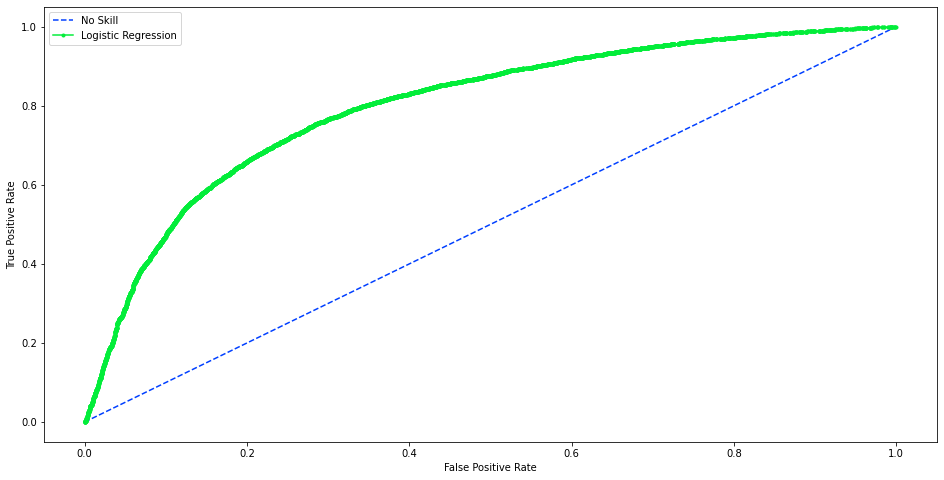

In [115]:
generate_roc(lr_gs.best_estimator_,y_test,'Logistic Regression')

### Feature Importance

**Scikit Learn Does not support the calculation of p-values, therefore the feature importance shown below is based on coefficients alone**

In [0]:
importances = np.absolute(lr_gs.best_estimator_.coef_[0])
features = X_train.columns
indices = np.argsort(importances)

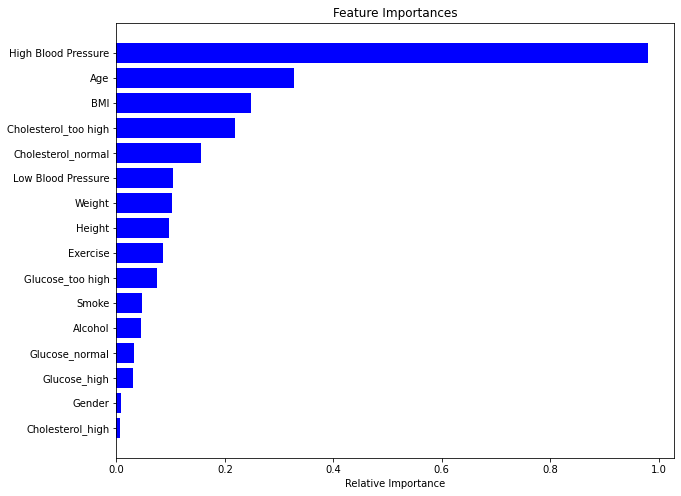

In [285]:
plt.figure(figsize = (10,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Best model table

**Due to a marginally higher value of Recall and accuracy, we choose the baseline model as the best model**

In [154]:
Model_comparison_LR = {'Model':['Baseline','Grid Search results'],
        'C' :[1.0,0.1759069582234977],            
        'solver':['lbfgs','newton-cg'],
        'max_iter':[100,100],
        'warm_start': [False,True],
        'Recall': [0.6944173743561186,0.6942781567590144],
        'Precision': [0.76,0.76],
        'Accuracy': [0.731358024691358,0.7312169312169312]
       }
pd.DataFrame(Model_comparison_LR)

,Model,C,solver,max_iter,warm_start,Recall,Precision,Accuracy
0,Baseline,1.000000,lbfgs,100,False,0.694417,0.76,0.731358
1,Grid Search results,0.175907,newton-cg,100,True,0.694278,0.76,0.731217


## Artificial Neural Networks

**Since this is a binary classification problem, we have one output node for all of our Artificial Neural Networks. We use sigmoid as the activation function for our output nodes because the sigmoid function returns a value between 0 and 1. Additionally, we use binary_crossentropy as our loss function.**

### Zero Hidden Layers

**The baseline model for zero hidden layers gives us an accuracy of 0.72 and a recall of 0.68**

In [0]:
ann0 = Sequential()
ann0.add(Dense(1, activation='sigmoid'))

ann0.compile(loss='binary_crossentropy', optimizer='sgd')

In [36]:
ann0.fit(x=X_train,y = y_train)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1034/1034 [==============================] - 1s 1ms/step - loss: 0.6148


In [37]:
pred = np.stack(ann0.predict_classes(X_test),axis =1)[0]

print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("F1 Score: ",f1_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      6992
           1       0.75      0.68      0.71      7183

    accuracy                           0.72     14175
   macro avg       0.72      0.72      0.72     14175
weighted avg       0.72      0.72      0.72     14175

Accuracy Score:  0.7211992945326279
Recall Score:  0.6814701378254211
F1 Score:  0.7124144957065929


Predicted,0,1,All
True,,,
0,5328,1664,6992
1,2288,4895,7183
All,7616,6559,14175


#### Optimization

**In order to optimize the neural network, the following hyperparameters were tuned:**

- **optimizer: We tried various optimizers including sgd,adam,rmsprop and adagrad. We found that sgd and adam produced the best results**
- **batch_size: Larger batch sizes seemed to lead to better performance, a batch size of 50 produced the best performance**
- **epochs: In order to find the best value for epoch, the early stopping method was used.The early stopping method keeps track of the training loss and the validation loss and stops execution when the model starts to overfit**

In [0]:
ann0 = Sequential()
ann0.add(Dense(1, activation='sigmoid'))

ann0.compile(loss='binary_crossentropy', optimizer='sgd')

In [0]:
early_stop = EarlyStopping(monitor='val_loss',mode="min",patience=20)

In [172]:
ann0.fit(x=X_train,y = y_train,epochs=1000,validation_data=(X_test,y_test),
          callbacks = [early_stop],batch_size = 50)

Epoch 1/1000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

662/662 [==============================] - 1s 2ms/step - loss: 0.6562 - val_loss: 0.5687
Epoch 2/1000
662/662 [==============================] - 1s 2ms/step - loss: 0.5676 - val_loss: 0.5584
Epoch 3/1000
662/662 [==============================] - 1s 2ms/step - loss: 0.5637 - val_loss: 0.5573
Epoch 4/1000
662/662 [==============================] - 1s 2ms/step - loss: 0.5631 - val_loss: 0.5577
Epoch 5/1000
662/662 [==============================] - 1s 2ms/step - loss: 0.5630 - val_loss: 0.557

#### Model Loss

**The below figure shows the number of epochs at which the loss values flatten out, we have selected a patience value of 20, which means that the model will continue to execute for 20 epochs after the curve flattens to ensure that there is no subsequent change in loss value**

In [0]:
model_loss = pd.DataFrame(ann0.history.history)

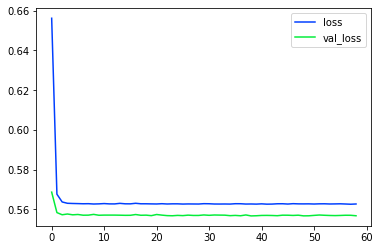

In [174]:
model_loss.plot()

In [0]:
pred = np.stack(ann0.predict_classes(X_test),axis =1)[0]
annpred0 = pred

In [176]:
print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("F1 Score: ",f1_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6992
           1       0.76      0.70      0.72      7183

    accuracy                           0.73     14175
   macro avg       0.73      0.73      0.73     14175
weighted avg       0.73      0.73      0.73     14175

Accuracy Score:  0.7321340388007055
Recall Score:  0.6959487679242656
F1 Score:  0.7247553461399058


Predicted,0,1,All
True,,,
0,5379,1613,6992
1,2184,4999,7183
All,7563,6612,14175


#### ROC Curve
**The ROC Curve can be seen below, it has an AUC value of 0.799**

No Skill: ROC AUC=0.500
ANN 0: ROC AUC=0.799


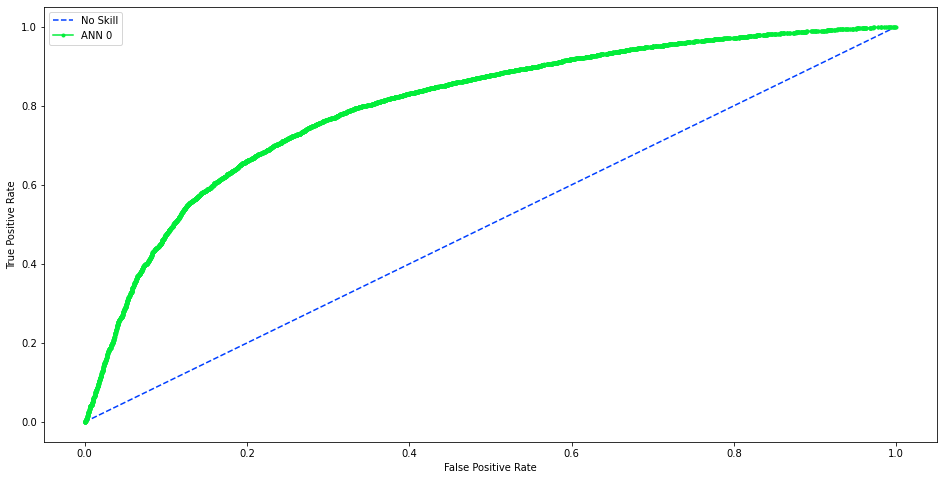

In [52]:
generate_ann_roc(ann0,y_test,'ANN 0')

#### Best Model Table

**Due to higher accuracy and recall values, we select the tuned model as the best model**

In [177]:
Model_comparison_ANN0 = {'Model':['Baseline','Tuning results'],
        'optimizer' :['sgd','sgd'],            
        'batch_size':[32,50],                              
        'epochs':[1,59],
        'Recall': [0.6814701378254211,0.6959487679242656],
        'Precision': [0.75,0.76],
        'Accuracy': [0.7211992945326279,0.7321340388007055]
       }
pd.DataFrame(Model_comparison_ANN0)

,Model,optimizer,batch_size,epochs,Recall,Precision,Accuracy
0,Baseline,sgd,32,1,0.681470,0.75,0.721199
1,Tuning results,sgd,50,59,0.695949,0.76,0.732134


### One Hidden Layer

**The baseline model for zero hidden layers gives us an accuracy of 0.73 and a recall of 0.69**

In [0]:
ann1 = Sequential()
ann1.add(Dense(16))

ann1.add(Dense(1, activation='sigmoid'))

ann1.compile(loss='binary_crossentropy', optimizer='sgd')

In [54]:
ann1.fit(x=X_train,y = y_train)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1034/1034 [==============================] - 1s 1ms/step - loss: 0.5972


In [55]:
pred = np.stack(ann1.predict_classes(X_test),axis =1)[0]

print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("F1 Score: ",f1_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6992
           1       0.76      0.69      0.72      7183

    accuracy                           0.73     14175
   macro avg       0.73      0.73      0.73     14175
weighted avg       0.73      0.73      0.73     14175

Accuracy Score:  0.7291005291005291
Recall Score:  0.6885702352777391
F1 Score:  0.7203612001165162


Predicted,0,1,All
True,,,
0,5389,1603,6992
1,2237,4946,7183
All,7626,6549,14175


#### Optimization

**In order to optimize the neural network, the following hyperparameters were tuned:**

- **optimizer: We tried various optimizers including sgd,adam,rmsprop and adagrad. We found that sgd and adam produced the best results**
- **batch_size: Larger batch sizes seemed to lead to better performance, the default batch size of 32 gives the best results**
- **epochs: In order to find the best value for epoch, the early stopping method was used.The early stopping method keeps track of the training loss and the validation loss and stops execution when the model starts to overfit**
- **Hidden layer Nodes: The number of nodes in the hidden layer.**

In [0]:
ann1 = Sequential()
ann1.add(Dense(12, activation='relu'))

ann1.add(Dense(1, activation='sigmoid'))

ann1.compile(loss='binary_crossentropy', optimizer='sgd')

In [0]:
early_stop = EarlyStopping(monitor='val_loss',mode="min",verbose=1,patience=25)

In [206]:
ann1.fit(x=X_train,y = y_train,epochs=1000,validation_data=(X_test,y_test),
          callbacks = [early_stop],batch_size = 32)

Epoch 1/1000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1034/1034 [==============================] - 2s 2ms/step - loss: 0.6106 - val_loss: 0.5748
Epoch 2/1000
1034/1034 [==============================] - 2s 2ms/step - loss: 0.5754 - val_loss: 0.5636
Epoch 3/1000
1034/1034 [==============================] - 2s 2ms/step - loss: 0.5682 - val_loss: 0.5583
Epoch 4/1000
1034/1034 [==============================] - 2s 2ms/step - loss: 0.5640 - val_loss: 0.5553
Epoch 5/1000
1034/1034 [==============================] - 2s 2ms/step - loss: 0.5614 - val_l

#### Model Loss

**The below figure shows the number of epochs at which the loss values flatten out, we have selected a patience value of 25, which means that the model will continue to execute for 25 epochs after the curve flattens to ensure that there is no subsequent change in loss value**

In [0]:
model_loss = pd.DataFrame(ann1.history.history)

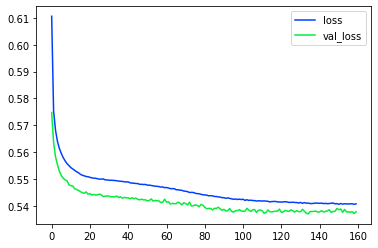

In [208]:
model_loss.plot()

In [0]:
pred = np.stack(ann1.predict_classes(X_test),axis =1)[0]
annpred1 = pred

In [210]:
print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("F1 Score: ",f1_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.72      0.75      0.74      6992
           1       0.75      0.72      0.73      7183

    accuracy                           0.74     14175
   macro avg       0.74      0.74      0.74     14175
weighted avg       0.74      0.74      0.74     14175

Accuracy Score:  0.7350970017636684
Recall Score:  0.719476541834888
F1 Score:  0.7335178482719468


Predicted,0,1,All
True,,,
0,5252,1740,6992
1,2015,5168,7183
All,7267,6908,14175


#### ROC Curve
**The ROC Curve can be seen below, it has an AUC value of 0.805**

No Skill: ROC AUC=0.500
ANN 1: ROC AUC=0.805


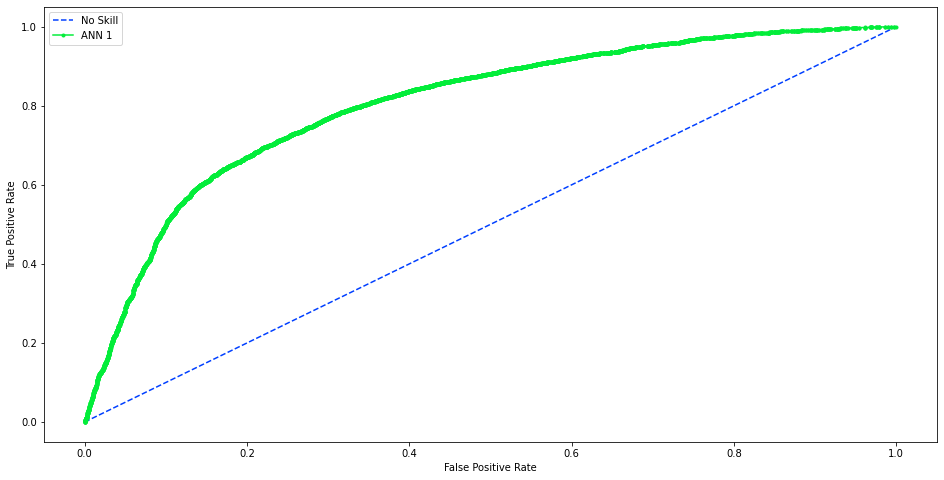

In [213]:
generate_ann_roc(ann1,y_test,'ANN 1')

#### Best Model Table

**Due to higher accuracy and recall values, we select the tuned model as the best model**

In [226]:
Model_comparison_ANN1 = {'Model':['Baseline','Tuning results'],
        'optimizer' :['sgd','sgd'],            
        'batch_size':[32,32],                              
        'epochs':[1,160],
        'Hidden Layer Nodes':[16,12],
        'Recall': [0.6885702352777391,0.719476541834888],
        'Precision': [0.76,0.75],
        'Accuracy': [0.7291005291005291,0.7350970017636684]
       }
pd.DataFrame(Model_comparison_ANN1)

,Model,optimizer,batch_size,epochs,Hidden Layer Nodes,Recall,Precision,Accuracy
0,Baseline,sgd,32,1,16,0.688570,0.76,0.729101
1,Tuning results,sgd,32,160,12,0.719477,0.75,0.735097


### Two Hidden Layers

**The baseline model for zero hidden layers gives us an accuracy of 0.73 and a recall of 0.71**

In [0]:
ann2 = Sequential()
ann2.add(Dense(16))
ann2.add(Dense(16))

ann2.add(Dense(1, activation='sigmoid'))

ann2.compile(loss='binary_crossentropy', optimizer='sgd')

In [215]:
ann2.fit(x=X_train,y = y_train)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1034/1034 [==============================] - 1s 1ms/step - loss: 0.5766


In [216]:
pred = np.stack(ann2.predict_classes(X_test),axis =1)[0]

print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("F1 Score: ",f1_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.72      0.75      0.73      6992
           1       0.75      0.71      0.73      7183

    accuracy                           0.73     14175
   macro avg       0.73      0.73      0.73     14175
weighted avg       0.73      0.73      0.73     14175

Accuracy Score:  0.730652557319224
Recall Score:  0.708339134066546
F1 Score:  0.7271687866228383


Predicted,0,1,All
True,,,
0,5269,1723,6992
1,2095,5088,7183
All,7364,6811,14175


#### Optimization

**In order to optimize the neural network, the following hyperparameters were tuned:**

- **optimizer: We tried various optimizers including sgd,adam,rmsprop and adagrad. We found that sgd and adam produced the best results**
- **batch_size: Larger batch sizes seemed to lead to better performance, the default batch size of 32 gives the best results**
- **epochs: In order to find the best value for epoch, the early stopping method was used.The early stopping method keeps track of the training loss and the validation loss and stops execution when the model starts to overfit**
- **Hidden layer Nodes: The number of nodes in each of the hidden layers.**

In [0]:
ann2 = Sequential()
ann2.add(Dense(12, activation='relu'))
ann2.add(Dense(12, activation='relu'))

ann2.add(Dense(1, activation='sigmoid'))

ann2.compile(loss='binary_crossentropy', optimizer='sgd')

In [0]:
early_stop = EarlyStopping(monitor='val_loss',mode="min",verbose=1,patience=15)

In [255]:
ann2.fit(x=X_train,y = y_train,epochs=1000,validation_data=(X_test,y_test),
          callbacks = [early_stop],batch_size = 32)

Epoch 1/1000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1034/1034 [==============================] - 2s 2ms/step - loss: 0.6374 - val_loss: 0.5890
Epoch 2/1000
1034/1034 [==============================] - 2s 2ms/step - loss: 0.5835 - val_loss: 0.5625
Epoch 3/1000
1034/1034 [==============================] - 2s 2ms/step - loss: 0.5677 - val_loss: 0.5536
Epoch 4/1000
1034/1034 [==============================] - 2s 2ms/step - loss: 0.5623 - val_loss: 0.5507
Epoch 5/1000
1034/1034 [==============================] - 2s 2ms/step - loss: 0.5593 - val_l

#### Model Loss

**The below figure shows the number of epochs at which the loss values flatten out, we have selected a patience value of 25, which means that the model will continue to execute for 25 epochs after the curve flattens to ensure that there is no subsequent change in loss value**

In [0]:
model_loss = pd.DataFrame(ann2.history.history)

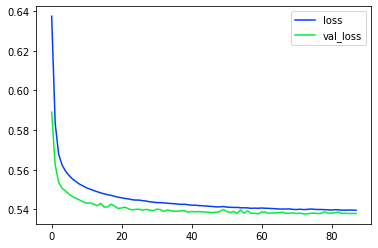

In [257]:
model_loss.plot()

In [0]:
pred = np.stack(ann2.predict_classes(X_test),axis =1)[0]
annpred2 = pred

In [259]:
print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("F1 Score: ",f1_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.72      0.77      0.75      6992
           1       0.76      0.71      0.73      7183

    accuracy                           0.74     14175
   macro avg       0.74      0.74      0.74     14175
weighted avg       0.74      0.74      0.74     14175

Accuracy Score:  0.7391887125220459
Recall Score:  0.7061116525128777
F1 Score:  0.7328950220359801


Predicted,0,1,All
True,,,
0,5406,1586,6992
1,2111,5072,7183
All,7517,6658,14175


#### ROC Curve
**The ROC Curve can be seen below, it has an AUC value of 0.804**

No Skill: ROC AUC=0.500
ANN 2: ROC AUC=0.804


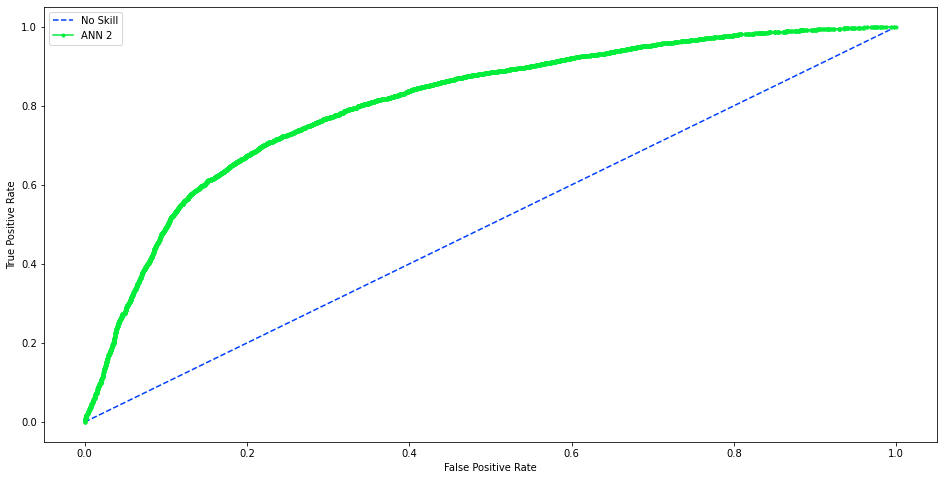

In [260]:
generate_ann_roc(ann2,y_test,'ANN 2')

#### Best Model Table

**Due to higher accuracy values, we select the tuned model as the best model**

In [261]:
Model_comparison_ANN2 = {'Model':['Baseline','Tuning results'],
        'optimizer' :['sgd','sgd'],            
        'batch_size':[32,32],                              
        'epochs':[1,160],
        'Hidden Layer 1 Nodes':[16,12],
        'Hidden Layer 2 Nodes':[16,12],
        'Recall': [0.708339134066546,0.7061116525128777],
        'Precision': [0.75,0.76],
        'Accuracy': [0.730652557319224,0.7391887125220459]
       }
pd.DataFrame(Model_comparison_ANN2)

,Model,optimizer,batch_size,epochs,Hidden Layer 1 Nodes,Hidden Layer 2 Nodes,Recall,Precision,Accuracy
0,Baseline,sgd,32,1,16,16,0.708339,0.75,0.730653
1,Tuning results,sgd,32,160,12,12,0.706112,0.76,0.739189


## Decision Trees

**The baseline model for Decision Trees has an accuracy of 0.62 and a recall of 0.63**

In [0]:
X = df_one_hot.drop('Disease',axis = 1)
y = df_one_hot['Disease']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [118]:
dtree = DecisionTreeClassifier()                        
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [119]:
pred = dtree.predict(X_test)
dt_pred = pred

print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("F1 Score: ",f1_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.62      0.61      0.61      6964
           1       0.63      0.64      0.63      7211

    accuracy                           0.62     14175
   macro avg       0.62      0.62      0.62     14175
weighted avg       0.62      0.62      0.62     14175

Accuracy Score:  0.6234215167548501
Recall Score:  0.6358341422826238
F1 Score:  0.6320650675489384


Predicted,0,1,All
True,,,
0,4252,2712,6964
1,2626,4585,7211
All,6878,7297,14175


### Optimization

**The following grid search returns the hyperparameters which provide the best results with a recall of 0.70 and an accuracy of 0.73**

**The hyperparameters tuned are**
- **criterion: The function used to measure the quality of a split.**
- **min_samples_split: The minimum number of samples required to split an internal node**
- **max_depth: Maximum number of levels that the decision tree can have**
- **min_samples_leaf: he minimum number of samples required to be at a leaf node.**
- **max_leaf_nodes: The maximum number of leaf nodes that the decision tree is allowed to have**

In [120]:
param_grid = {'criterion': ['gini', 'entropy'],
              'min_samples_split': [2, 10, 20],
              'max_depth': [5, 10, 20, 25, 30],
              'min_samples_leaf': [1, 5, 10],
              'max_leaf_nodes': list(range(25,50))}
dt_gs = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='recall',cv = 6,n_jobs=4,verbose=1)
dt_gs.fit(X_train, y_train)

Fitting 6 folds for each of 2250 candidates, totalling 13500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   45.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed: 10.5min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed: 12.3mi

GridSearchCV(cv=6, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                      

In [121]:
print(dt_gs.best_score_)

0.699969046362093


In [122]:
for hps, values in dt_gs.best_params_.items():
    print(f"{hps}: {values}")

criterion: gini
max_depth: 20
max_leaf_nodes: 49
min_samples_leaf: 10
min_samples_split: 2


In [0]:
pred = dt_gs.best_estimator_.predict(X_test)
dt_pred = pred

In [124]:
print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("F1 Score: ",f1_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.71      0.76      0.73      6964
           1       0.75      0.70      0.73      7211

    accuracy                           0.73     14175
   macro avg       0.73      0.73      0.73     14175
weighted avg       0.73      0.73      0.73     14175

Accuracy Score:  0.729594356261023
Recall Score:  0.7035085286368049
F1 Score:  0.7258029901995852


Predicted,0,1,All
True,,,
0,5269,1695,6964
1,2138,5073,7211
All,7407,6768,14175


### ROC Curve
**The ROC Curve can be seen below, it has an AUC value of 0.795**

No Skill: ROC AUC=0.500
Decision Trees: ROC AUC=0.795


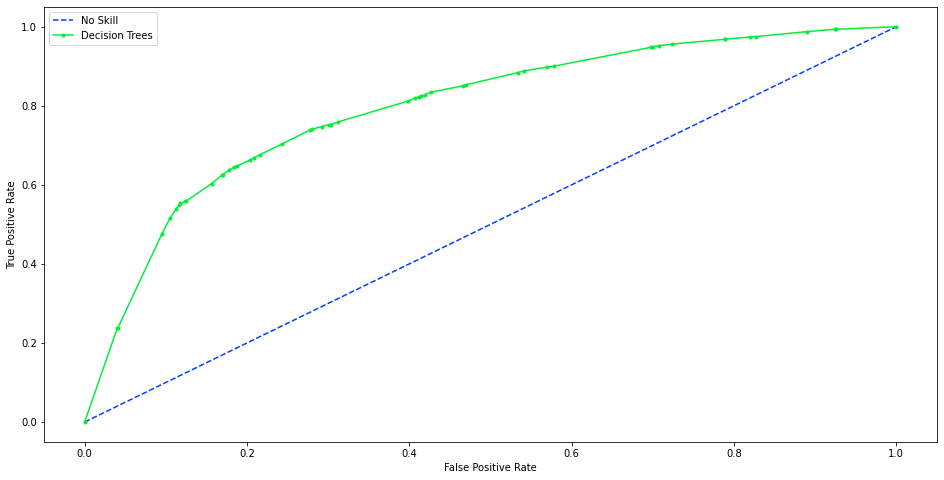

In [125]:
generate_roc(dt_gs.best_estimator_,y_test,'Decision Trees')

### Feature Importance

In [0]:
importances = dt_gs.best_estimator_.feature_importances_
features = X_train.columns
indices = np.argsort(importances)

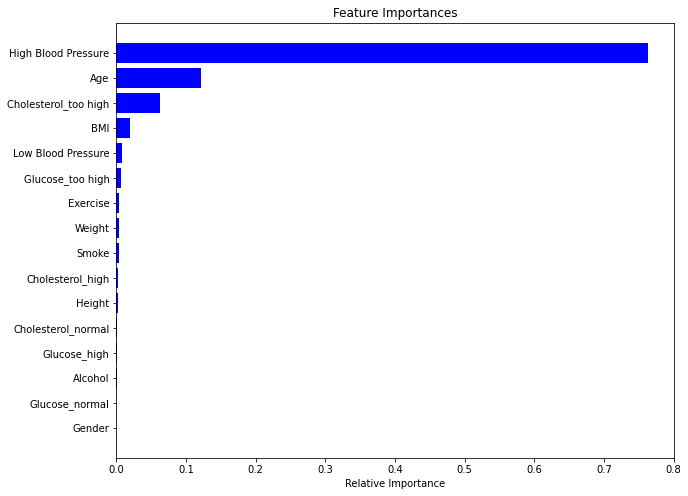

In [127]:
plt.figure(figsize = (10,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Best model table
**Due to a higher recall and accuracy values, we choose the grid search results as the best model**

In [157]:
Model_comparison_DT = {'Model':['Baseline','Grid Search results'],
        'criterion' :['gini','gini'],            
        'min_samples_split':[2,2],                              
        'max_depth':[None,20],
        'min_samples_leaf':[1,10],
        'max_leaf_nodes':[None,49],
        'Recall': [0.6358341422826238,0.7035085286368049],
        'Precision': [0.63,0.75],
        'Accuracy': [0.6234215167548501,0.729594356261023]
       }
pd.DataFrame(Model_comparison_DT)

,Model,criterion,min_samples_split,max_depth,min_samples_leaf,max_leaf_nodes,Recall,Precision,Accuracy
0,Baseline,gini,2,NaN,1,NaN,0.635834,0.63,0.623422
1,Grid Search results,gini,2,20.0,10,49.0,0.703509,0.75,0.729594


# Model Comparison

**The below table compares the different models**

In [286]:
Model_comparison_GBM = {'Model':['Logistic Regression','Decision Tree','ANN0','ANN1','ANN2','K Nearest Neighbor','Naive bayes','Random Forest'\
                                 ,'Gradient Boosting','Linear Support Vector Machines','Non Linear Support Vector Machines'],
        'Accuracy':[0.731358024691358,0.729594356261023,0.7321340388007055,0.7350970017636684,0.7391887125220459,0.7300176366843033,\
                    0.712804,0.738765,0.737496,0.730794,0.7311463844797178],            
        'Recall':[0.6944173743561186,0.7035085286368049,0.719476541834888,0.719476541834888,0.7061116525128777,0.6931922398589065,\
                  0.653627,0.688113,0.713629,0.688013,0.7030488653765836],
        'Hyperparameters':['solver,C,solver,max_iter,warm_start','criterion,min_samples,max_depth,min_samples_leaf,max_leaf_nodes',\
                           'optimizer,batch_size,epochs','optimizer,batch_size,epochs,Hidden Layer Nodes',\
                           'optimizer,batch_size,epochs,Hidden Layer 1 Nodes,Hidden Layer 2 Nodes','n_neighbors,weights,algorithm,p',\
                           'alpha,fit_prior','n_estimators,max_depth,min_samples_split,criterion,min_samples_leaf',\
                           'n_estimators,loss,learning_rate,max_depth,min_samples_split,max_features,subsample',\
                           'C,dual,loss,penalty,max_iter','C,gamma,kernel'],
        'Time':['15 seconds','15 seconds','30 seconds','2 minutes','3 minutes','1 minute','15 seconds','1 minute','5 minutes','10 minutes',\
                '15 mins']
       }
pd.DataFrame(Model_comparison_GBM).sort_values(by='Accuracy',ascending=False)

,Model,Accuracy,Recall,Hyperparameters,Time
4,ANN2,0.739189,0.706112,"optimizer,batch_size,epochs,Hidden Layer 1 Nod...",3 minutes
7,Random Forest,0.738765,0.688113,"n_estimators,max_depth,min_samples_split,crite...",1 minute
8,Gradient Boosting,0.737496,0.713629,"n_estimators,loss,learning_rate,max_depth,min_...",5 minutes
3,ANN1,0.735097,0.719477,"optimizer,batch_size,epochs,Hidden Layer Nodes",2 minutes
2,ANN0,0.732134,0.719477,"optimizer,batch_size,epochs",30 seconds
0,Logistic Regression,0.731358,0.694417,"solver,C,solver,max_iter,warm_start",15 seconds
10,Non Linear Support Vector Machines,0.731146,0.703049,"C,gamma,kernel",15 mins
9,Linear Support Vector Machines,0.730794,0.688013,"C,dual,loss,penalty,max_iter",10 minutes
5,K Nearest Neighbor,0.730018,0.693192,"n_neighbors,weights,algorithm,p",1 minute
1,Decision Tree,0.729594,0.703509,"criterion,min_samples,max_depth,min_samples_le...",15 seconds


## Comparison between Decision Tree, Logistic Regression and Ensemble Learning

- **Decision Tree and Gradient Boosting are nearly identical in terms of the most important features, both models list High Blood Pressure, Low Blood Pressure, BMI, Cholesterol too high and age among the most important features**
- **Decision Tree and Random Forest are also similar in terms of important features, both models list High Blood Pressure, Low Blood Pressure, BMI, Age, Weight and Cholesterol too high among the most important features**
- **Decision Tree and Logistic Regression have similar feature importance, both models list High Blood Pressure,age,BMI and Cholesterol too high among the most important features. However, logistic regression finds some attributes like cholesterol normal to be important whereas decision tree does not**

**Overall the four models are in general agreement over which features are the most important. High Blood pressure,Low Blood Pressure, Age, BMI and Cholesterol too high seem to be important across all the models**

## Comparison between Logistic Regression, Linear SVM and Single Layer Perceptron

**The three models have similar performances in terms of accuracy. Linear SVM and Perceptron are similar because both models attempt to classify data by drawing a linear hyperplane through the data in ordert to classify into different categories. Logistic regression is also a linear combination between the independant variables which draws a linear plane.**


**Additionally, logistic regression and ANN0 both find a linear combination of variables and apply the sigmoid function**

# Test Data Predictions

## Logistic Regression

In [262]:
lr_pred = lr_gs.best_estimator_.predict(df_test_standardized.drop('ID',axis = 1))
lr_pred

array([0, 0, 1, ..., 1, 1, 1])

## Decision Tree

In [263]:
dt_pred = dt_gs.best_estimator_.predict(df_test_one_hot.drop('ID',axis = 1))
dt_pred

array([0, 0, 0, ..., 0, 1, 1])

## Artificial Neural Network (Zero Hidden Layers)

In [264]:
ann0_pred = np.stack(ann0.predict_classes(df_test_standardized.drop('ID',axis = 1)),axis =1)[0]
ann0_pred

array([0, 0, 1, ..., 1, 1, 1], dtype=int32)

## Artificial Neural Network (One Hidden Layer)

In [265]:
ann1_pred = np.stack(ann1.predict_classes(df_test_standardized.drop('ID',axis = 1)),axis =1)[0]
ann1_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int32)

## Artificial Neural Network (Two Hidden Layers)

In [266]:
ann2_pred = np.stack(ann2.predict_classes(df_test_standardized.drop('ID',axis = 1)),axis =1)[0]
ann2_pred

array([0, 0, 1, ..., 0, 1, 0], dtype=int32)

## Exporting Training Data

In [267]:
data1 = {
    'ID' : df_testing.ID,
    'DT': dt_pred,
    'LR': lr_pred,
    'ANN0' : ann0_pred,
    'ANN1' : ann1_pred,
    'ANN2' : ann2_pred
}

final_result = pd.DataFrame(data1)
final_result.head()

,ID,DT,LR,ANN0,ANN1,ANN2
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,1,1,0,1
3,3,1,1,1,1,1
4,4,0,0,0,0,0


In [0]:
final_result.to_csv('final.csv',index = False)

# Conclusion

**In conclusion, all the algorithms work fairly well with accuracy's ranging between 72-74 percent. We find that Artificial Neural Networs and logistic Regression are among the best performing models for this dataset. The two ensemble learning models also proved to be highly effective in predicting whether or not a patient has the disease**